In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
from functools import partial

In [2]:
g = 9.81

def ddt(mu, state, t):
    #some of these have been complicated with newton's 2nd law in polar coord form
    rdotdot = (g*(-mu+np.cos(state[2])) + state[0]*state[3]**2) / (1+mu)
    thetadotdot = (-g*np.sin(state[2])-2*state[1]*state[3])/state[0]
    return np.array([state[1],rdotdot,state[3],thetadotdot]) #r, rdot, theta, thetadot

def rk4(mu, state, t, dt):
    f0 = ddt(mu, state, t)
    f1 = ddt(mu, state+f0*(dt/2), t + dt/2)
    f2 = ddt(mu, state+f1*(dt/2), t + dt/2)
    f3 = ddt(mu, state+f2*(dt), t + dt)
    s_next = state + (f0 + 2 * f1 + 2 * f2 + f3) * dt / 6
    return s_next

In [3]:
def SAM(mu, init_state, t, show):
    states=[init_state] #this captures all necessary params: r, rdot, theta, thetadot
    times = [0]
    dt = 0.005
    threshold = 0.005

    for i in range(int(t/dt)):
        if(states[-1][0] < threshold * init_state[0]):
            print("Possible singularity. Stopping simulation. (r=%.3f)"%states[-1][0])
            break
        if(states[-1][0] > init_state[0]/threshold):
            print("Possible unbounded solution. Stopping simulation. (r=%.3f)"%states[-1][0])
            break
        states.append(rk4(mu, states[-1], times[-1], dt))
        times.append(times[-1] + dt)
        
    
    # transform and transpose
    states = np.array(states)
    states = states.transpose()

    if show:
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        ax.set_theta_zero_location("S")
        ax.plot(states[2], states[0], color='r', linewidth=1)
        plt.title("$\mu = %.3f$, $r_0 = %.3f$, $\\dot{r_0} = %.3f$, $\\theta_0 = %.3f$, $\\dot{\\theta_0} = %.3f$" % (mu, init_state[0], init_state[1], init_state[2], init_state[3]))
        ax.grid(True)
    return states

array([[ 2.        ,  1.99992336,  1.99969344, ...,  1.5317064 ,
         1.54007809,  1.5484863 ],
       [ 0.        , -0.03065742, -0.06130808, ...,  1.67028308,
         1.67819017,  1.68489611],
       [ 1.57079633,  1.57073501,  1.57055105, ...,  1.00594462,
         1.0217697 ,  1.03728818],
       [ 0.        , -0.02452657, -0.04906253, ...,  3.19586985,
         3.13425687,  3.07323683]])

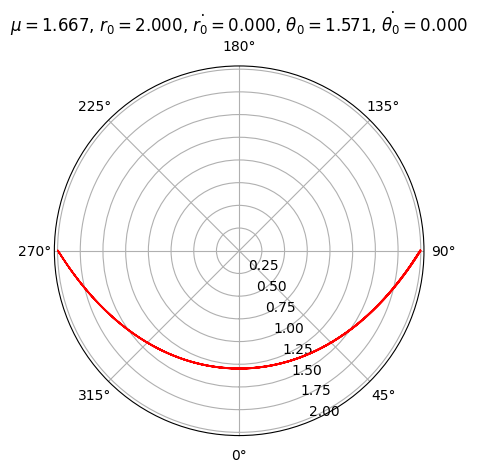

In [4]:
SAM(1.667, np.array([2,0,np.pi/2,0]), 10, True) #known periodic orbit

Possible singularity. Stopping simulation. (r=0.005)


array([[ 2.00000000e+00,  1.99988852e+00,  1.99955410e+00, ...,
         6.05366793e-02,  3.14300347e-02,  5.41272762e-03],
       [ 0.00000000e+00, -4.45906357e-02, -8.91796305e-02, ...,
        -5.83369999e+00, -5.77390526e+00, -3.48916623e+00],
       [ 1.57079633e+00,  1.57073501e+00,  1.57055103e+00, ...,
        -8.79982224e+00, -8.44224282e+00, -5.21208936e+00],
       [ 0.00000000e+00, -2.45272785e-02, -4.90682317e-02, ...,
         3.76946482e+01,  1.39774280e+02,  3.82272899e+03]])

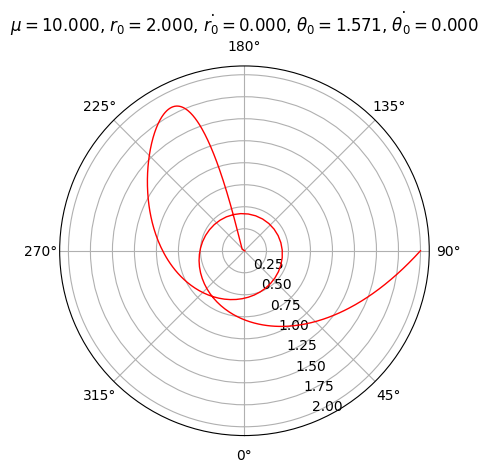

In [5]:
SAM(10, np.array([2,0,np.pi/2,0]), 10, True) #known singular orbit

array([[ 2.        ,  1.9849202 ,  1.96968082, ...,  1.60187449,
         1.58964859,  1.57720726],
       [-3.        , -3.03191923, -3.06382843, ..., -2.42359032,
        -2.46674645, -2.50976019],
       [ 0.1       ,  0.1035203 ,  0.10708193, ..., -2.02527575,
        -2.02035202, -2.01521123],
       [ 0.7       ,  0.70815676,  0.71652971, ...,  0.96348537,
         1.00622627,  1.05031802]])

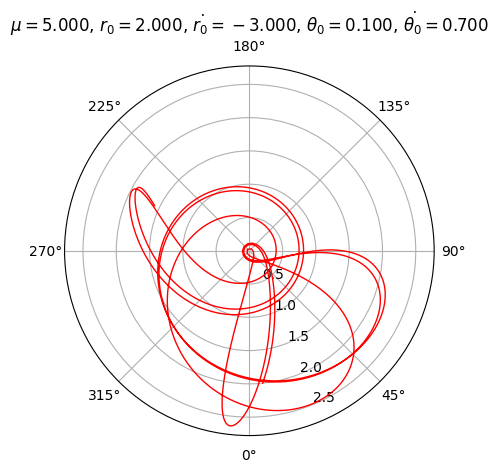

In [6]:
SAM(5, np.array([2,-3,0.1,0.7]), 10, True) #some initial velocity

In [6]:
def update(frame, scatter, line, res, interval):
    line.set_xdata(res[2][:min(frame*int(interval/5), len(res[0])-1)])
    line.set_ydata(res[0][:min(frame*int(interval/5), len(res[0])-1)])
    scatter.set_offsets([res[2][min(frame*int(interval/5), len(res[0])-1)], res[0][min(frame*int(interval/5), len(res[0])-1)]])
    return [line, scatter]

def anim(mu, state, t, interval):
    res = SAM(mu, state, t, False)
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.set_theta_zero_location("S")
    line = ax.plot(res[2], res[0], color='r', linewidth=1)[0]
    ax.grid(True)
    scatter = ax.scatter(res[2], res[0], s=90, c='black')

    ani = animation.FuncAnimation(fig=fig, func=partial(update, line=line, scatter=scatter, res=res, interval=interval), frames=int(len(res[0])*5/interval), interval=interval)

    i = 1
    filename = "example_mu" + str(mu) + ".gif"
    if os.path.exists(filename):
        while os.path.exists("example_mu%.3f_%s.gif" % (mu, i)):
            i += 1
        filename = "example_mu%.3f_%s.gif" % (mu, i)
    ani.save(filename=filename, writer="pillow", fps=int(1000/interval))

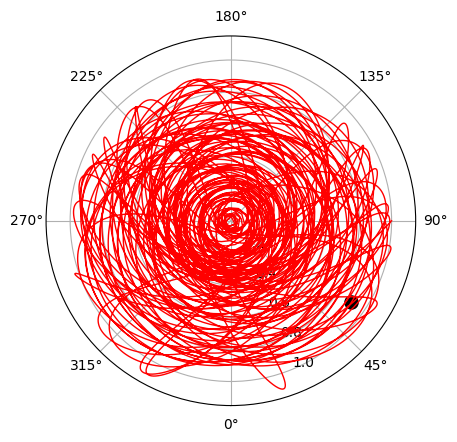

In [7]:
anim(10.3, np.array([1, 0, np.pi/2, 0]), 60, 30)